Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
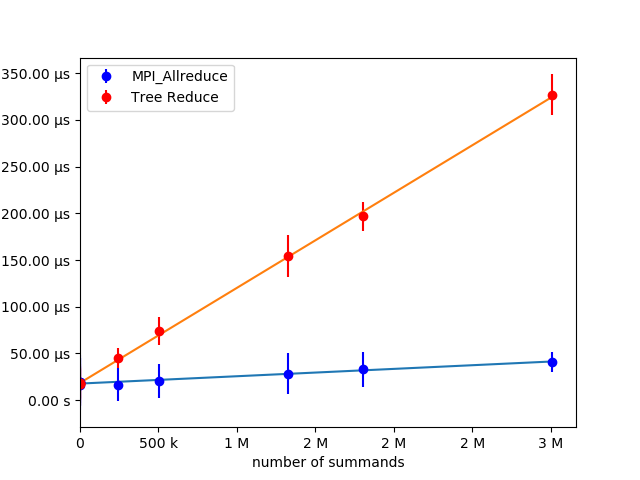

In [1]:
%matplotlib widget
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import EngFormatter
from scipy.stats import linregress

# warning: not safe from SQL injection
def fetch_data(cluster_size, mode):
    con = sqlite3.connect('file:results.db?mode=ro', uri=True)
    cur = con.cursor()
    
    cur.execute(f"SELECT n_summands, datafile, time_ns, stddev FROM results WHERE mode = ? AND cluster_size = ?",
               (mode, cluster_size))


    a = cur.fetchall()
    con.close()
    return a

def datasets():
    with sqlite3.connect('file:results.db?mode=ro', uri=True) as con:
        cur = con.cursor()

def xye(data):
    x = list(map(lambda x: x[0], data)) # n_summands
    y = list(map(lambda x: x[2] / 1e9, data)) # time_ns
    e = list(map(lambda x: x[3] / 1e9, data)) # stddev
    return x, y, e


cluster_size = 128

settings = {
    "allreduce": {
        "fmt": "bo",
        "label": "MPI_Allreduce",
        "include": True,
    },
    "tree": {
        "fmt": "ro",
        "label": "Tree Reduce",
        "include": True
    },
    "baseline": {
        "fmt": "go",
        "label": "Sequential Baseline",
        "include": False
    }
}
linreg = True

f = plt.figure()
ax = f.subplots(1)
ax.set_ylabel('Accumulate Time')
ax.set_xlabel('number of summands')

formatter0 = EngFormatter(unit='s', places=2)
formatter1 = EngFormatter(places=0)
ax.yaxis.set_major_formatter(formatter0)
ax.xaxis.set_major_formatter(formatter1)

for mode, v in settings.items():
    if not v["include"]:
        continue
    
    ar_x, ar_y, ar_error = xye(fetch_data(cluster_size, mode))
    ax.errorbar(ar_x, ar_y, yerr=ar_error, fmt=v["fmt"], label=v["label"])
    
    if linreg:
        settings[mode]["linreg"] = linregress(ar_x, ar_y)
        gradient, intercept, r_value, p_value, std_err = settings[mode]["linreg"]
        x1 = np.linspace(min(ar_x), max(ar_x), 50)
        y1 = gradient * x1 + intercept
        plt.plot(x1, y1)

ax.legend(loc='upper left')

ax.set_xlim(left=0)
#ax.set_ylim(bottom=0)

plt.show()
plt.savefig(fname="figure.svg")



In [2]:
from IPython.display import HTML, display

def display_table(data, header = []):
    html = "<table>"
    if len(header) > 0:
        html += "<tr>" + "".join(["<th>" + h + "</th>" for h in header])
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td>%s</td>"%(field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

if linreg:
    header = ["Mode", "Gradient", "R"]
    t = [((mode,
          settings[mode]["linreg"][0],
          settings[mode]["linreg"][2]) if settings[mode]["include"] else []) for mode in settings.keys()]
    display_table(t, header=header)
    

Mode,Gradient,R
allreduce,7.85813341658207e-12,0.9823195736918079
tree,1.0170134650090749e-10,0.9996677264679752


In [3]:
if linreg:
    slowdown = settings["tree"]["linreg"][0] / settings["allreduce"]["linreg"][0]
    display(HTML(f"<h3>Tree Reduce slowdown compared to Allreduce: {round(slowdown,2)}"))